## EDA: Advanced Feature Extraction.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
from subprocess import check_output 
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go 
import plotly.tools as tls 
import os 
import gc #garbage collection
import re #regular expression = used for string searching and manipulation
# nltk = natural language toolkit = to work with human language data
import nltk
nltk.download()
from nltk.corpus import stopwords 
import distance 
#stemming = mapping a group of words to the same stem. for ex: fish, fishes, fishing = fish(stem)
from nltk.stem import PorterStemmer
#Beautiful Soup transforms a complex HTML document into a complex tree of Python objects
from bs4 import BeautifulSoup 
# fuzzywuzzy uses a score out of 100, that denotes two string are equal by giving similarity index.
from fuzzywuzzy import fuzz 
# for dimanesionality reduction
from sklearn.manifold import TSNE 
# WordCloud is a technique to show which words are the most frequent among the given text.
from wordcloud import WordCloud, STOPWORDS 
from os import path
from PIL import Image 

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [2]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv('df_fe_without_preprocessing_train.csv', encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print('get df_fe_without_processing_train.csv from drive or run the previous notebook')

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,word_common
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,,,66,57,14,12,10.0,23.0,0.434783,,,10.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1.0,,51,88,8,13,4.0,20.0,0.200000,,,4.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,,1.0,73,59,14,10,4.0,24.0,0.166667,,,4.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,4.0,,50,65,11,9,0.0,19.0,0.000000,,,0.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1.0,1.0,76,39,13,7,2.0,20.0,0.100000,2.0,0.0,2.0


### Preprocessing of Text 
* Removing html tags 
* Removing punctuations 
* Performing Stemming 
* Removing Stopwords like of, or, and 
* Expanding contractions etc.

In [4]:
SAFE_DIV = 0.0001

STOP_WORDS = stopwords.words('english')

def preprocess(x):
    x = str(x).lower()
    x = x.replace(',000,000', 'm').replace(',000', 'k').replace("′", "'").replace("’", "'")\
         .replace("won't", 'will not').replace('cannot', 'can not').replace("can't", 'can not')\
         .replace("n't", ' not').replace("what's", 'what is').replace("is's", 'it is')\
         .replace("'ve'", ' have').replace("i'm", 'i am').replace("'re", ' are')\
         .replace("he's", 'he is').replace("she's", 'she is').replace("'s", ' own')\
         .replace("%", " percent ").replace("₹", ' rupee ').replace("$", ' dollar ')\
         .replace("€", ' euro ').replace("'ll", ' will ')
    
    # re.sub() function is used to replace occurrences of a particular sub-string with another sub-string in a string 
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    porter = PorterStemmer()
    
    # \W Matches any character which is not a word character.
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
        
    return x

    

### Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if Last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  use to know how much % two strings are similar 
<br>
<br>

- __fuzz_partial_ratio__ : comparing two strings by using their substrings, if any substring matches then it will give 100% similarity percentage 
<br>
<br>

- __token_sort_ratio__ : used when the strings comparison the same, but they are in a different order. it sorts all the tokens and then compare
<br>
<br>


- __token_set_ratio__ : finds similarity percentage of two strings having different lengths 
<br>
<br>


- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [5]:
def get_token_features(q1, q2):
    # list with all zeroes 
    token_features = [0.0]*10 
    
    #Converting the sentence into tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    # getting the words from the questions 
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    # getting stop words from the questions 
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # getting common tokens from the question pairs 
    common_token_count = len(set(q1_tokens.intersection(set(q2_tokens))))
    
    # getting common words from the question pairs 
    common_word_count = len(q1_words.intersection(q2_words))
    
    # getting common stopwords from the question pairs
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    
    return token_features   

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0  
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1) 
                             
def extract_features(df):
    # preprocessing each question
    df['question1'] = df['question1'].fillna('').apply(preprocess)    
    df['question2'] = df['question2'].fillna('').apply(preprocess)                       
                             
                             
    # Token features:- 
    # Adding all the token features as new columns into dataset
    token_features = df.apply(lambda x: get_token_features(x['question1'], x['question2']), axis=1)
    df['cwc_min'] = list(map(lambda x: x[0], token_features))
    df['cwc_max'] = list(map(lambda x: x[1], token_features))                         
    df['csc_min'] = list(map(lambda x: x[2], token_features))
    df['csc_max'] = list(map(lambda x: x[3], token_features))                         
    df['ctc_min'] = list(map(lambda x: x[4], token_features))                         
    df['ctc_max'] = list(map(lambda x: x[5], token_features))                         
    df['last_word_eq'] = list(map(lambda x: x[6], token_features))                         
    df['first_word_eq'] = list(map(lambda x: x[7], token_features))     
    df['abs_len_diff'] = list(map(lambda x: x[8], token_features))                         
    df['mean_len'] = list(map(lambda x: x[9], token_features))                         
                             
    # Fuzzy features:- 
    # Adding fuzzy features as new columns into dataset                          
    df['fuzz_ratio'] = df.apply(lambda x: fuzz.QRatio(x['question1'], x['question2']), axis=1)
    df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']), axis=1)                         
    df['token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']), axis=1)
    df['token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']), axis=1)                         
    df['longest_substr_ratio'] = df.apply(lambda x: get_longest_substr_ratio(x['question1'], x['question2']), axis=1)                         
    
    return df                         
                             

In [6]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv('nlp_features_train.csv', encoding='latin-1')
    df.fillna('')
else:
    print('Extracting features for train:')
    df = pd.read_csv('train.csv')
    df = extract_features(df)
    df.to_csv('nlp_features_train.csv', index=False)

df.head()   

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


### Analysis of extracted features

#### Plotting word cloud 

* Creating word cloud of similar and non similar question pairs 
* We can observe the most frequently occuring words 

In [7]:
df_similar = df[df['is_duplicate'] == 1]
df_nonsimilar = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2}, {3,4}} to {1,2,3,4}
'''
a = [
      [0, 3],
      [1, 4],
      [2, 5]
    ]
b = [
      [6,  9],
      [7, 10],
      [8, 11]
    ]
# Shape of each array is [3,2]
'''
''' 
# the dstack function adds a 3rd axis, which means each of the arrays end up looking like this:
a = [
      [[0], [3]],
      [[1], [4]],
      [[2], [5]]
    ]
b = [
      [[6],  [9]],
      [[7], [10]],
      [[8], [11]]
    ]
# Shape of each array is [3,2,1]
'''
'''
dstack([a,b]) = [
                  [[0, 6], [3, 9]],
                  [[1, 7], [4, 10]],
                  [[2, 8], [5, 11]]
                ]
# Shape of the combined array is [3,2,2]
'''
s = np.dstack([df_similar['question1'], df_similar['question2']]).flatten()
ns = np.dstack([df_nonsimilar['question1'], df_nonsimilar['question2']]).flatten()

print('Number of data points in class 1(Similar question pairs) = ', len(s))
print('Number of data points in class 0(Disimilar question pairs) = ', len(ns))

# Saving the np array into a text file 
np.savetxt('train_s.txt', s, delimiter=' ', fmt='%s', encoding='latin-1')
np.savetxt('train_ns.txt', ns, delimiter=' ', fmt='%s', encoding='latin-1')

Number of data points in class 1(Similar question pairs) =  298526
Number of data points in class 0(Disimilar question pairs) =  510054


- Reading the text files and removing the stop words 

In [8]:
# current directory 
d = path.dirname('.')

texts_w = open(path.join(d, 'train_s.txt')).read()
textns_w = open(path.join(d, 'train_ns.txt')).read()

stopwords = set(STOPWORDS)
print('Total number of words in similar question pairs = ', len(texts_w))
print('Total number of words in non similar question pairs', len(textns_w))


Total number of words in similar question pairs =  16109886
Total number of words in non similar question pairs 33193130


- Word clouds generated from similar pair question's text 

Word cloud for similar question pairs


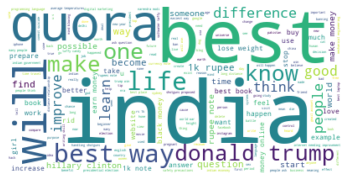

In [9]:
wc = WordCloud(background_color='white', max_words=len(texts_w), stopwords=stopwords)
wc.generate(texts_w)

print('Word cloud for similar question pairs')

#  used to display data as an image
# interpolation='bilinear' = It is a texture mapping technique that produces a reasonably realistic image used for resampling 
# ‘resampling’ is the process of altering an images resolution by either adding or removing extra pixels.
plt.imshow(wc, interpolation='bilinear')
# used to unshow the x and y axis on which it it plotted
plt.axis('off')
plt.show()

- Word clouds generated from non similar pair question's text

Word cloud for non similar question pairs


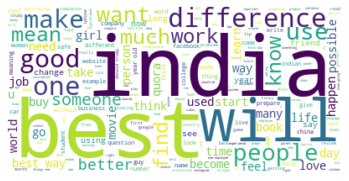

In [10]:
wc = WordCloud(background_color='white', max_words=len(textns_w), stopwords=stopwords)
wc.generate(textns_w)

print('Word cloud for non similar question pairs')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

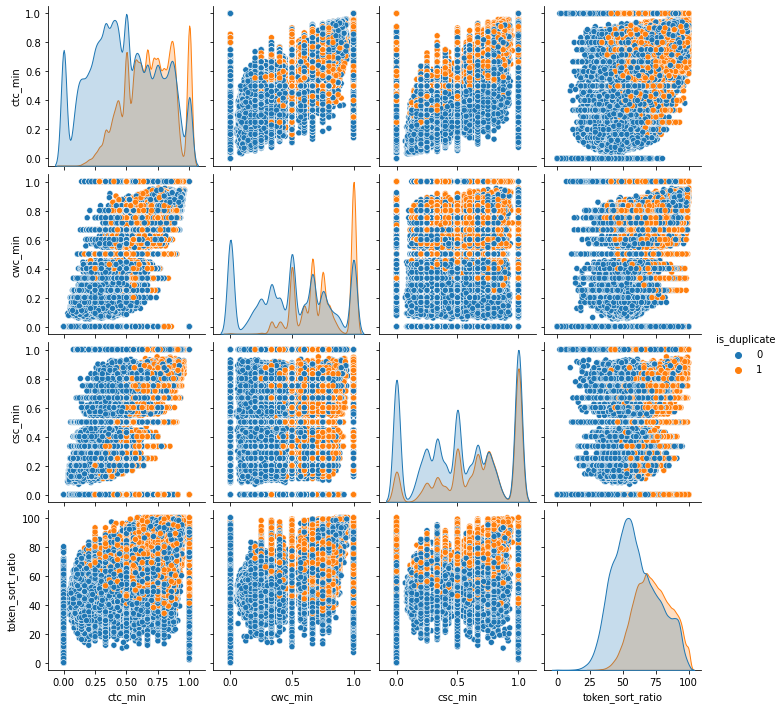

In [11]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show() 

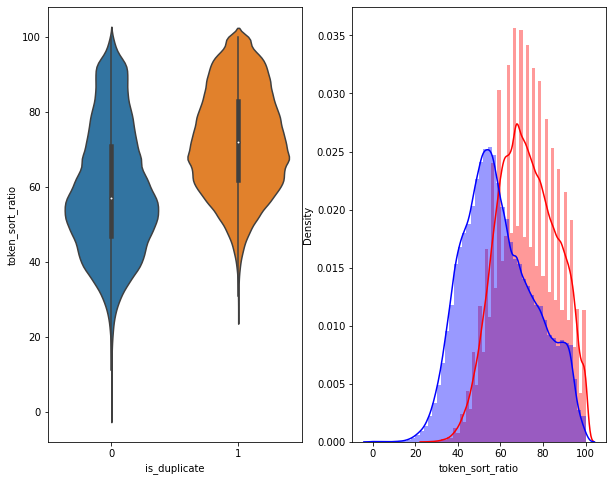

In [15]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:], )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:], label = '1', color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:], label = '0', color = 'blue')
plt.show()

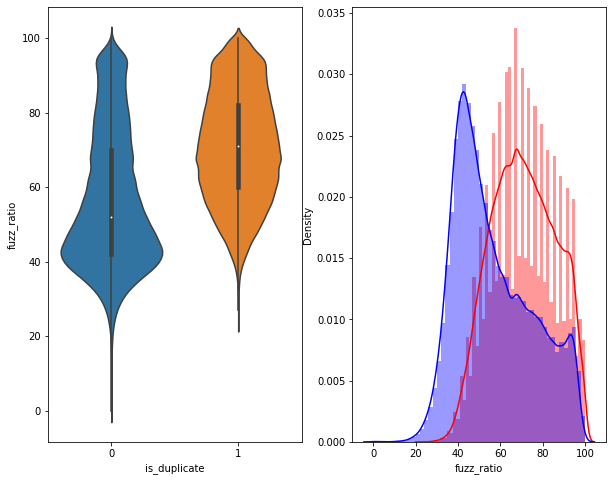

In [16]:
# Distribution of the fuzz_ratio 

plt.figure(figsize = (10,8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:], )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:], label = '1', color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:], label = '0', color = 'blue')
plt.show()

### Visualization 

In [18]:
# Dimensionality reduction of 15 features (generated after cleaning the data) to 2 dimension

from sklearn.preprocessing import MinMaxScaler

df_subsampled = df[0:5000]

X = MinMaxScaler().fit_transform(df_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio']])
y = df_subsampled['is_duplicate'].values

In [19]:
tsne2d = TSNE(
    n_components = 2,
    init = 'random',
    random_state = 101,
    method = 'barnes_hut',
    n_iter = 1000,
    verbose = 2,
    angle = 0.5 
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.040s...
[t-SNE] Computed neighbors for 5000 samples in 0.493s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.240s
[t-SNE] Iteration 50: error = 80.9631577, gradient norm = 0.0438191 (50 iterations in 1.214s)
[t-SNE] Iteration 100: error = 70.4331512, gradient norm = 0.0101722 (50 iterations in 0.851s)
[t-SNE] Iteration 150: error = 68.6522141, gradient norm = 0.0061401 (50 iterations in 0.838s)
[t-SNE] Iteration 200: error = 67.8018494, gradient norm = 0.0042288 (50 iterations in 0.879s)
[t-SNE] Iteration 250: error = 67.3057709, gradient norm = 0.0034214

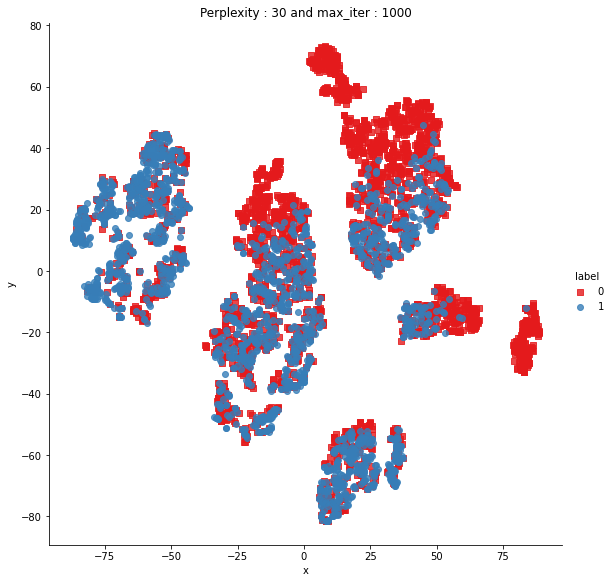

In [21]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1], 'label':y})

sns.lmplot(data = df, x = 'x', y = 'y', hue = 'label', fit_reg = False, size = 8, palette = 'Set1', markers = ['s', 'o'])
plt.title('Perplexity : {} and max_iter : {}'.format(30, 1000))
plt.show()


In [22]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components = 3,
    init = 'random',
    random_state = 101, 
    method = 'barnes_hut',
    n_iter = 1000,
    verbose = 2,
    angle = 0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.026s...
[t-SNE] Computed neighbors for 5000 samples in 0.484s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.224s
[t-SNE] Iteration 50: error = 80.3959732, gradient norm = 0.0322760 (50 iterations in 2.699s)
[t-SNE] Iteration 100: error = 69.1394196, gradient norm = 0.0036235 (50 iterations in 1.771s)
[t-SNE] Iteration 150: error = 67.6493530, gradient norm = 0.0018707 (50 iterations in 1.685s)
[t-SNE] Iteration 200: error = 67.0882950, gradient norm = 0.0011860 (50 iterations in 1.721s)
[t-SNE] Iteration 250: error = 66.7617722, gradient norm = 0.0009069

In [23]:
trace1 = go.Scatter3d(
    x = tsne3d[:,0],
    y = tsne3d[:,1],
    z = tsne3d[:,2],
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line = dict(color = 'rgb(255, 255, 255)'),
        opacity = 0.75
    )
)

data = [trace1]
layout = dict(height = 800, width = 800, title = '3d embedding with engineered features')
fig = dict(data = data, layout = layout)
py.iplot(fig, filename = '3DBubble')